# Final Project - E-Commerce: Product Range Analysis

# Project description

**In order to increase sales, our client, an E-Commerce business, have asked us to analyze the store's product range.**

**In the process of product range analysis, we will take a closer look at our products and our clients' behaviour. <br>
Analysis of the product range can help us bundle our products into clusters which will help displaying the products to the users in more comfortable way and help us competently offer additional products to buyers and optimize purchases, and eventually make decisions on whether we need to refresh our stock with more exciting products of the same category or remove other products from our inventory.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats as st
import numpy as np
import seaborn as sns
import difflib
from statistics import mode
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import nltk
from nltk.stem.snowball import SnowballStemmer

snow_stemmer = SnowballStemmer(language='english')

In [2]:
def up(df, column):
    return df.sort_values(by = column, ascending = False)
    
def down(df, column):
    return df.sort_values(by = column, ascending = True)

## Download and preprocess the data

### Open the data file and study the general information

In [3]:
df = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep = '\t',
                 parse_dates = ['InvoiceDate'])

In [4]:
print(df.info())
missing_values = df.isnull().sum().reset_index().rename(columns = {0: 'missing_values'})
print(df.describe())
missing_values['%'] = (missing_values['missing_values'] / 541909) * 100
missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB
None
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000

,index,missing_values,%
0,InvoiceNo,0,0.000000
1,StockCode,0,0.000000
2,Description,1454,0.268311
3,Quantity,0,0.000000
4,InvoiceDate,0,0.000000
5,UnitPrice,0,0.000000
6,CustomerID,135080,24.926694


**Looking at the information, we have 7 columns, all columns need their name to be changed according to the convention. let's see how we can preprocess each of them individually.**

**1) InvoiceNo - Need to look for anomal values. We can see this column is defined as object, so there might be some wrong values in that column. Also since invoice numbers are individual, we need to check that there are no duplicates based on the number, date(make sure this number was used only in specific date) and customer ID(make sure no 2 customers recived the same invoice number at the same day).**

**2) StockCode - Also make sure there are no anomal values. Make sure there aren't several products with the same code.**

**3) Description - Need make sure all the descriptions actually contain a product.
We have 0.26% of missing values, we can try fill them with using the stock_code and mode() method.**

**4) Quantity - Looking at the descrpition above, looks like there will be anomalies. We can't have quantity with negative value and probably not with such a high number such as the max value in that column.**

**5) InvoiceDate - Look at the range of the dates, make sure it makes sence, and change the data type to date type.**

**6) UnitPrice - Also contain anomalies according to the description. The price has to be positive and be reasonable. If necessary, we can use the mode() method to fill prices with anormal values.**

**7) CustomerID - Almost 25% of missing values. We can try using the mode() method on the invoice_number to fill null values in this column. Other than that, we might not be able to use those rows to calculate retention rate, but we can still use them for the product range analysis.**

### Preprocess the data

#### **Changing column names according to convention, and making sure there are only lower case letters in the dataframe in order to find duplicates.**

In [5]:
df.rename(columns = {'InvoiceNo':   'invoice_number',
                     'StockCode':   'stock_code',
                     'Description': 'description',
                     'Quantity':    'quantity',
                     'InvoiceDate':   'invoice_date',
                     'UnitPrice':   'unit_price',
                     'CustomerID':   'customer_id',}, inplace=True)
df = df.applymap(lambda s:s.lower() if type(s) == str else s)
df.head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,536365,85123a,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,white metal lantern,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406b,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029g,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029e,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850.0


#### Looking for duplicates

In [6]:
print('Number of duplicated rows: {}({:.2%})'.format(df.duplicated().sum(), df.duplicated().sum() / len(df)))

Number of duplicated rows: 5268(0.97%)


In [7]:
df = df.drop_duplicates()

In [8]:
df[df['invoice_number'] == 'a563185']

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
299982,a563185,b,adjust bad debt,1,2019-08-10 14:50:00,11062.06,NaN


#### invoice_number column:

In [9]:
letters_in_invoice = df[(df['invoice_number'].str.contains('[a-zA-Z]'))].reset_index()
letters_in_invoice.head()

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,141,c536379,d,discount,-1,2018-11-29 09:41:00,27.50,14527.0
1,154,c536383,35004c,set of 3 coloured flying ducks,-1,2018-11-29 09:49:00,4.65,15311.0
2,235,c536391,22556,plasters in tin circus parade,-12,2018-11-29 10:24:00,1.65,17548.0
3,236,c536391,21984,pack of 12 pink paisley tissues,-24,2018-11-29 10:24:00,0.29,17548.0
4,237,c536391,21983,pack of 12 blue paisley tissues,-24,2018-11-29 10:24:00,0.29,17548.0


**Some invoices start with a letter. They also have negative quantity. Let's see if there are letters other than c in the invoice numbers**

In [10]:
letters_in_invoice['invoice_number'] = letters_in_invoice['invoice_number'].str.replace('\d+', '', regex = True)

In [11]:
letters_in_invoice['invoice_number'].unique()

array(['c', 'a'], dtype=object)

**There are numbers with the letters 'a' and 'c'.<br>
Let's look at invoices that contain the letter 'a':**

In [12]:
a_in_invoice = letters_in_invoice[letters_in_invoice['invoice_number'] == 'a']
a_in_invoice

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
5436,299982,a,b,adjust bad debt,1,2019-08-10 14:50:00,11062.06,NaN
5437,299983,a,b,adjust bad debt,1,2019-08-10 14:51:00,-11062.06,NaN
5438,299984,a,b,adjust bad debt,1,2019-08-10 14:52:00,-11062.06,NaN


**We don't know yet what the 'c' means, but the 'a' is not for item purchases, so we can drop rows with 'a' in the invoice number.**

In [13]:
df.drop(a_in_invoice['index'], inplace = True)
df = df.reset_index(drop = True)

In [14]:
c_in_invoice = df[(df['invoice_number'].str.contains('[c]'))].reset_index()
print('Number of invoice numbers with c in them:', len(c_in_invoice))
print('Number of invoice numbers with c in them and negative quantity:', len(c_in_invoice[c_in_invoice['quantity'] <= 0]))

Number of invoice numbers with c in them: 9251
Number of invoice numbers with c in them and negative quantity: 9251


In [15]:
df.drop(c_in_invoice['index'], inplace = True)
df = df.reset_index(drop = True)

**All the invoice numbers that contain the letter c has negative quantity. We can ask the data engineers what does it mean, but meanwhile we can drop it.**

#### stock_code column:

In [16]:
letters_in_code = df[(df['stock_code'].str.contains('[a-zA-Z]'))].reset_index()
letters_in_code.head()

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,0,536365,85123a,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850.0
1,2,536365,84406b,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850.0
2,3,536365,84029g,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850.0
3,4,536365,84029e,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850.0
4,45,536370,post,postage,3,2018-11-29 08:45:00,18.00,12583.0


**Let's separate codes with only letters from codes that combine letters and numbers.**

In [17]:
letters = letters_in_code[letters_in_code['stock_code'].str.isalpha()]
letters.groupby('stock_code')['description'].value_counts()

stock_code  description               
amazonfee   amazon fee                       2
dcgssboy    boys party bag                  11
dcgssgirl   girls party bag                 13
dot         dotcom postage                 708
m           manual                         323
pads        pads to match all cushions       4
post        postage                       1126
s           samples                          2
Name: description, dtype: int64

**Only boys' and girls' party bags are actually products. Let's drop the rest.**

In [18]:
drop = letters[(letters['stock_code'] != 'dcgssboy') & (letters['stock_code'] != 'dcgssgirl')]
df.drop(drop['index'], inplace = True)

In [19]:
combine = df[(~df['stock_code'].str.isdigit()) & (~df['stock_code'].str.isalpha())].reset_index(drop = True)
combine.head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,536365,85123a,white hanging heart t-light holder,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,84406b,cream cupid hearts coat hanger,8,2018-11-29 08:26:00,2.75,17850.0
2,536365,84029g,knitted union flag hot water bottle,6,2018-11-29 08:26:00,3.39,17850.0
3,536365,84029e,red woolly hottie white heart.,6,2018-11-29 08:26:00,3.39,17850.0
4,536373,85123a,white hanging heart t-light holder,6,2018-11-29 09:02:00,2.55,17850.0


In [20]:
combine['stock_number'] = combine['stock_code'].str.replace('[a-zA-Z]', '', regex = True)
num_descriptions = combine.groupby('stock_number')['description'].nunique().reset_index()
more_than_1 = num_descriptions[num_descriptions['description'] > 1]
len(more_than_1)

296

In [21]:
more_than_1.head()

,stock_number,description
1,0003,2
8,0069,2
16,10124,2
17,15044,4
18,15056,3


**There are 296 stock codes that have letter in their stock code. Let's look at a sample and see if we can come up with conclusions.**

In [22]:
print(df[df['stock_code'].str.contains('15044')]['stock_code'].unique())
df[df['stock_code'].str.contains('15044')]['description'].unique()

['15044b' '15044c' '15044d' '15044a']


array(['blue paper parasol ', 'purple paper parasol', 'red paper parasol',
       'pink paper parasol ', nan], dtype=object)

**Looks like the letters in stock_code column implies the same product have several versions (different colors in that case.)<br>
After I'll finish the preprocess, I will count the number of versions for each item.**

#### description column:

**Let's take a look at the the rows with missing description.**

In [23]:
df[(df['description'].isna())].head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
596,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,NaN
1922,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN
1923,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,NaN
1924,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,NaN
1925,536549,85226a,NaN,1,2018-11-29 14:34:00,0.0,NaN


**Let's take a look at the stock_code of the first row and see if we can find the description.**

In [24]:
df[(df['stock_code'] == '22139')].head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
106,536381,22139,retrospot tea set ceramic 11 pc,23,2018-11-29 09:41:00,4.25,15311.0
596,536414,22139,NaN,56,2018-11-29 11:52:00,0.00,NaN
6215,536942,22139,amazon,15,2018-12-01 12:08:00,0.00,NaN
6700,536982,22139,retrospot tea set ceramic 11 pc,10,2018-12-01 14:27:00,11.02,NaN
7018,537011,22139,NaN,-5,2018-12-01 15:38:00,0.00,NaN


**We have found very peculiar resaults. Same stock_code have 2 different descriptions. One is the "amazon" description that I can't tell anything about it yet and the other is probably the actual description. We will address the "amazon" description and negative quantity issues later.**

**Meanwhile, let's find stock codes with more than 1 description that we can try use to fill the NaN values or with 0 descriptions - only NaN values**

In [25]:
code_desc_num = df.groupby('stock_code')['description'].nunique().reset_index()
code_desc_num[(code_desc_num['description'] > 1) | (code_desc_num['description'] == 0)]

,stock_code,description
1,10080,2
4,10123g,0
8,10133,2
9,10134,0
23,15058a,2
...,...,...
3926,dcgs0069,2
3928,dcgs0071,0
3929,dcgs0072,0
3931,dcgs0074,0


In [26]:
df['description'] = df.groupby('stock_code')['description'].transform(lambda grp:grp.fillna(grp.mode().max()))

**Left with stock codes that only have NaN as desription, thus we can't fill their values so we have to drop them.**

In [27]:
df.dropna(subset = ['description'], inplace = True)

In [28]:
def more_than_1(df, column_1, column_2):
    num_descriptions = df.groupby(column_1)[column_2].nunique().reset_index()
    more_than_1 = num_descriptions[num_descriptions[column_2] > 1].reset_index(drop = True)
    more_than_1 = more_than_1.rename({column_2: 'num_of_descriptions'}, axis=1)
    display(up(more_than_1, 'num_of_descriptions').head(10))

In [29]:
more_than_1(df, 'stock_code', 'description')

,stock_code,num_of_descriptions
314,23084,7
25,20713,7
621,85175,6
137,21830,6
68,21181,5
620,85172,5
506,72807a,5
386,23343,5
333,23131,5
464,37327,4


**Still have codes with more than one description. I will use the mode() method again to make sure each code have one description.<br>
NOTE: We had descriptions such as "broken" or "damaged". Those descriptions usually had no customer ID or had negative quantity or price, so this bad rows will be addressed in the following stages.**

In [30]:
df['description'] = df.groupby('stock_code')['description'].transform(lambda grp:mode(grp))

In [31]:
more_than_1(df, 'stock_code', 'description')

,stock_code,num_of_descriptions


**Made unified description for each stock_code.**

#### quantity column:

In [32]:
none_to_negative = df[df['quantity'] <= 0].reset_index()
none_to_negative.head()

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,2336,536589,21777,recipe box with metal heart,-10,2018-11-29 16:50:00,0.0,NaN
1,4249,536764,84952c,mirror love bird t-light holder,-38,2018-11-30 14:42:00,0.0,NaN
2,7003,536996,22712,card dolly girl,-20,2018-12-01 15:30:00,0.0,NaN
3,7004,536997,22028,penny farthing birthday card,-20,2018-12-01 15:30:00,0.0,NaN
4,7005,536998,85067,cream sweetheart wall cabinet,-6,2018-12-01 15:30:00,0.0,NaN


**Looks like lot of the negative quantities also have no price and customer_id.<br>
Let's see how many of the rows are such.**

In [33]:
print('Missing customer ID:', len(none_to_negative[none_to_negative['customer_id'].isna()]))
print('Missing customer ID with no price:', len(none_to_negative[(none_to_negative['unit_price'] == 0) &
                                                                 (none_to_negative['customer_id'].isna())]))
print('Number of mutual invoice numbers for the original df and none_to_negative df:', len(df[df['invoice_number'].isin(none_to_negative['invoice_number'])]))

Missing customer ID: 1235
Missing customer ID with no price: 1235
Number of mutual invoice numbers for the original df and none_to_negative df: 1235


**We have found that all of the rows with negative quantities also have no price and customer_id.<br>
Also made sure each invoice number in the none_to_negative only appears once in the original df.**

In [34]:
df.drop(none_to_negative['index'], inplace = True)
df = df.reset_index(drop = True)

In [35]:
df[df['quantity'] <= 0]

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id


#### invoice_date column:

In [36]:
df['invoice_date'].describe(datetime_is_numeric = True)

count                           523868
mean     2019-07-02 14:48:15.227919872
min                2018-11-29 08:26:00
25%                2019-03-26 11:58:00
50%                2019-07-18 11:22:00
75%                2019-10-17 11:41:00
max                2019-12-07 12:50:00
Name: invoice_date, dtype: object

**The first and last dates of purchases make sence. Also made sure the column is in date type while reading the data frame.**

#### unit_price column:

In [37]:
df[df['unit_price'] <= 0].head()

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
594,536414,22139,retrospot tea set ceramic 11 pc,56,2018-11-29 11:52:00,0.0,NaN
1918,536546,22145,christmas craft heart stocking,1,2018-11-29 14:33:00,0.0,NaN
1919,536547,37509,new england mug w gift box,1,2018-11-29 14:33:00,0.0,NaN
1951,536553,37461,funky monkey mug,3,2018-11-29 14:35:00,0.0,NaN
4236,536765,84952c,mirror love bird t-light holder,19,2018-11-30 14:43:00,0.0,NaN


In [38]:
none_to_negative = df[df['unit_price'] <= 0].reset_index()
none_to_negative.head()

,index,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,594,536414,22139,retrospot tea set ceramic 11 pc,56,2018-11-29 11:52:00,0.0,NaN
1,1918,536546,22145,christmas craft heart stocking,1,2018-11-29 14:33:00,0.0,NaN
2,1919,536547,37509,new england mug w gift box,1,2018-11-29 14:33:00,0.0,NaN
3,1951,536553,37461,funky monkey mug,3,2018-11-29 14:35:00,0.0,NaN
4,4236,536765,84952c,mirror love bird t-light holder,19,2018-11-30 14:43:00,0.0,NaN


In [39]:
df['unit_price'] = df.groupby('stock_code')['unit_price'].transform(lambda grp:mode(grp))
df['unit_price'] = df.groupby('description')['unit_price'].transform(lambda grp:mode(grp))

In [40]:
print('Number of units with negative price: ', len(df[df['unit_price'] < 0]))
print('Number of units with 0 price: ', len(df[df['unit_price'] == 0]))

Number of units with negative price:  0
Number of units with 0 price:  45


**We still have rows with 0 as unit price. It occured because some stock codes or descriptions don't have any price in the df so we couldn't replace the 0 with the mode() method. I will dro those rows.**

In [41]:
df = df[df['unit_price'] > 0].reset_index(drop = True)

#### customer_id column:

In [42]:
missing_id = df[df['customer_id'].isna()]
print('% of missing customer ID: {:.2%}'.format(len(missing_id) / len(df))) 

% of missing customer ID: 25.30%


**We have 25% of the rows with missing customer ID. Let's see if we can fill them. I will use the invoice number and see if I can find customer ID for the invoice number in the original df**

In [43]:
invoice_list = missing_id['invoice_number'].unique()

In [44]:
df[(df['invoice_number'].isin(invoice_list)) & (df['customer_id'].notna())]

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id


**There are no rows with missing customer ID that have customer ID in the original df.<br>
I will leave the missing cusomer ID as they are since it won't affect us too much in the proccess.**

In [45]:
df[(df['invoice_number'] == '536409') & (df['description'] == 'union jack flag luggage tag')]

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
483,536409,21866,union jack flag luggage tag,1,2018-11-29 11:45:00,1.25,17908.0


## Exploratory data analysis

### Outliers

**After preprocessing the data, let's use the describe() method again to see if we still have outliers in the quantity and unit_price columns.**

#### quantity column:

In [46]:
df['quantity'].describe()

count    523823.000000
mean         10.743963
std         157.859565
min           1.000000
25%           1.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: quantity, dtype: float64

**There are high outliers in the quantity column. it is not reasonable to order over 80 thousand units of any item. Let's look at the boxplot.**

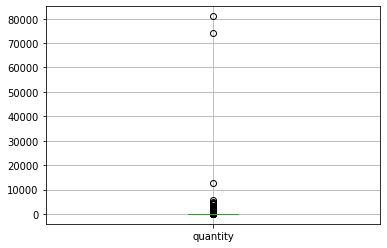

In [47]:
df.boxplot('quantity')

plt.show()

**We can see in the boxplot that there are several significant outliers that we need to get rid of.<br> Let's set the higher limit to 10,000 units. It is reasonable to order small items in bulks this size.**

In [48]:
df = df.query('quantity < 10000')

up(df, 'quantity').head(10)

,invoice_number,stock_code,description,quantity,invoice_date,unit_price,customer_id
72085,542504,37413,icon mug revolutionary,5568,2019-01-26 12:03:00,0.39,NaN
407391,573008,84077,world war 2 gliders asstd designs,4800,2019-10-25 12:26:00,0.29,12901.0
199093,554868,22197,popcorn holder,4300,2019-05-25 10:52:00,0.85,13135.0
213329,556231,85123a,white hanging heart t-light holder,4000,2019-06-07 15:04:00,2.95,NaN
94040,544612,22053,empire design rosette,3906,2019-02-20 10:43:00,1.25,18087.0
261670,560599,18007,essential balm 3.5g tin in envelope,3186,2019-07-17 17:04:00,0.18,14609.0
154934,550461,21108,fairy cake flannel assorted colour,3114,2019-04-16 13:20:00,0.79,15749.0
50898,540815,21108,fairy cake flannel assorted colour,3114,2019-01-09 12:55:00,0.79,15749.0
254943,560040,23343,jumbo bag vintage christmas,3100,2019-07-12 14:28:00,2.08,NaN
419207,573995,16014,small chinese style scissor,3000,2019-10-31 11:24:00,0.42,16308.0


**Now the highest quantity is less than 6,000 which is OK. The highest quantities are for cheap items that can be ordered in big bulks.**

#### unit_price column

In [49]:
df['unit_price'].describe()

count    523820.000000
mean          2.831028
std           3.658990
min           0.040000
25%           1.250000
50%           1.950000
75%           3.750000
max         165.000000
Name: unit_price, dtype: float64

**In the unit price column, we do have outliers, but they are not un-reasonable. It makes sence that a product would cost 165$\$$ , or 0.06$\$$ , so I will leave it as it is**

### Product analysis

#### Number of purchases by date column

In [50]:
df['date'] = pd.to_datetime(df['invoice_date'].dt.date)
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month 
df['week'] = df['invoice_date'].dt.isocalendar().week

In [51]:
daily_total = df.groupby(['date', 'week' ,'month', 'year']).agg({'invoice_number': 'nunique'}).reset_index()
daily_total.rename(columns = {'invoice_number':'daily_purchases'}, inplace = True)
dap = daily_total.copy()
dap['daily_purchases'] = dap['daily_purchases'].mean()
dap_num = dap.loc[0, 'daily_purchases']
dap = dap.groupby(['week','month', 'year']).mean()
dap = dap.sort_values(by = ['year', 'month', 'week'], ascending = True)

In [52]:
weekly_dap = daily_total.groupby(['week','month', 'year']).mean()
weekly_dap = weekly_dap.sort_values(by = ['year', 'month', 'week'], ascending = True)
weekly_dap.reset_index(inplace = True)
weekly_dap.rename(columns = {'daily_purchases':'weekly_dap'}, inplace = True)

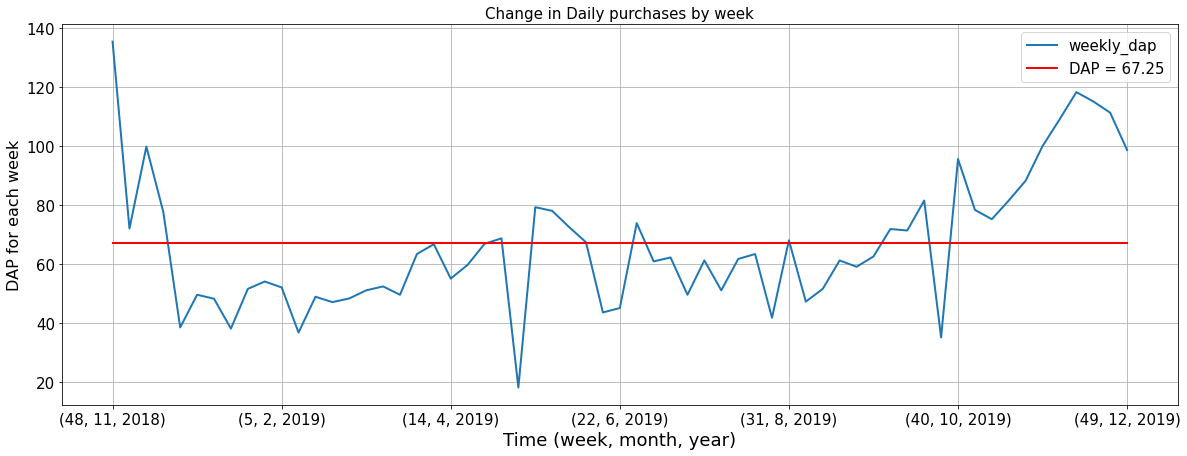

In [53]:
ax = weekly_dap.plot(y = 'weekly_dap', figsize = (20, 7), grid = True, fontsize = 15,   linewidth = 2)
dap.plot(y = 'daily_purchases',figsize = (20, 7), grid = True, fontsize = 15, color = 'r', ax = ax, label = 'DAP = {:.2f}'.format(dap_num), linewidth = 2)
plt.title('Change in Daily purchases by week', fontsize = 15)
plt.xlabel('Time (week, month, year)', fontsize=18)
plt.ylabel('DAP for each week', fontsize=16)
plt.legend(prop={'size': 15})

plt.show()

**The graph above shows the daily average number of purchases for every week. we can see pattern that's probably affected by the time of the year, with rise in sales before the holidays, and much less sales on the holidays themselves and on Easter time.**

#### Individual items and invoices analysis

**Starting to find our flagship products by analyzing products' total quantity and total revenue.<br> I will also add the unit price and number of invoices each item is in.<br>
I will assign position for each item in each of these fields from top to bottom.**

In [54]:
def position(df, column):
    for i in range(0, len(df)):
        df.loc[i, column + '_position'] = i + 1
    return df

In [55]:
df['revenue'] = df['unit_price'] *  df['quantity']

**I'll start with counting unique versions for items with letters in their stock_code**

In [56]:
combine = df[(~df['stock_code'].str.isdigit()) & (~df['stock_code'].str.isalpha())].reset_index(drop = True)
combine['stock_number'] = combine['stock_code'].str.replace('[a-zA-Z]', '', regex = True)
num_descriptions = combine.groupby('stock_number')['description'].nunique().reset_index()
num_descriptions.rename(columns={'description': 'num_versions'}, inplace=True)

In [57]:
df['stock_number'] = df['stock_code'].str.replace('[a-zA-Z]', '', regex = True)
df = df.merge(num_descriptions, on = 'stock_number', how = 'outer')
df['num_versions'].fillna('1', inplace = True)
df['num_versions'] = df['num_versions'].astype('int8')
df['more_than_1'] = df['num_versions'].apply(lambda x: True if (x > 1) else False)

In [58]:
items = df.groupby(['stock_code', 'description']).agg({'quantity':'sum', 'unit_price':'mean', 'revenue':'sum', 'num_versions':'mean', 'more_than_1': 'mean'}).reset_index()
items.rename(columns={'revenue': 'total_revenue'}, inplace=True)

In [59]:
items_revenue = position(up(items, 'total_revenue').reset_index(drop = True), 'total_revenue')

In [60]:
items_quantity = position(up(items, 'quantity').reset_index(drop = True), 'quantity')

In [61]:
items_price = position(up(items, 'unit_price').reset_index(drop = True), 'unit_price')

In [62]:
items_invoice_count = df.groupby('stock_code')['invoice_number'].count().reset_index()
up(items_invoice_count, 'invoice_number').reset_index(drop = True)
items_invoice_count.rename(columns = {'invoice_number': 'invoice_count'}, inplace = True)
items_invoice_count = position(items_invoice_count, 'invoice_count')

In [63]:
positions = pd.merge(items_revenue, items_quantity,  how = 'left', left_on = ['stock_code','description', 'quantity', 'unit_price', 'total_revenue', 'num_versions', 'more_than_1'], right_on = ['stock_code','description', 'quantity', 'unit_price', 'total_revenue', 'num_versions', 'more_than_1'])
positions = pd.merge(positions, items_price,  how = 'left', left_on = ['stock_code','description', 'quantity', 'unit_price', 'total_revenue', 'num_versions', 'more_than_1'], right_on = ['stock_code','description', 'quantity', 'unit_price', 'total_revenue', 'num_versions', 'more_than_1'])
positions = pd.merge(positions, items_invoice_count,  how = 'left', left_on = ['stock_code',], right_on = ['stock_code'])

In [64]:
positions.filter(['stock_code', 'description', 'total_revenue_position', 'quantity_position', 'unit_price_position', 'invoice_count_position']).head()

,stock_code,description,total_revenue_position,quantity_position,unit_price_position,invoice_count_position
0,22423,regency cakestand 3 tier,1.0,37.0,103.0,1301.0
1,85123a,white hanging heart t-light holder,2.0,4.0,1418.0,3295.0
2,85099b,jumbo bag red retrospot,3.0,3.0,1926.0,3279.0
3,47566,party bunting,4.0,20.0,773.0,2650.0
4,23084,rabbit night light,5.0,7.0,1921.0,1933.0


In [65]:
def scatter(title, x_col, y_col, xlabel, ylabel):
    positions.plot(kind = 'scatter', 
          x = x_col, 
          y = y_col, 
          figsize = (12,5),
          alpha = 0.4)
    plt.xlabel(xlabel, fontsize = 14)
    plt.ylabel(ylabel, fontsize = 14)
    plt.title(title, fontsize = 16)
    plt.show()

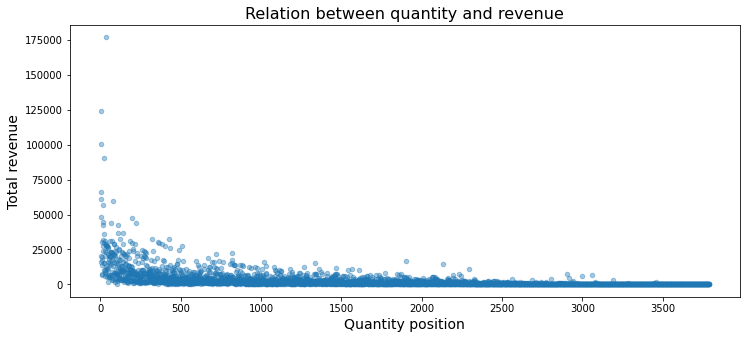

In [66]:
scatter('Relation between quantity and revenue',
     'quantity_position',
     'total_revenue',
     'Quantity position',
     'Total revenue')

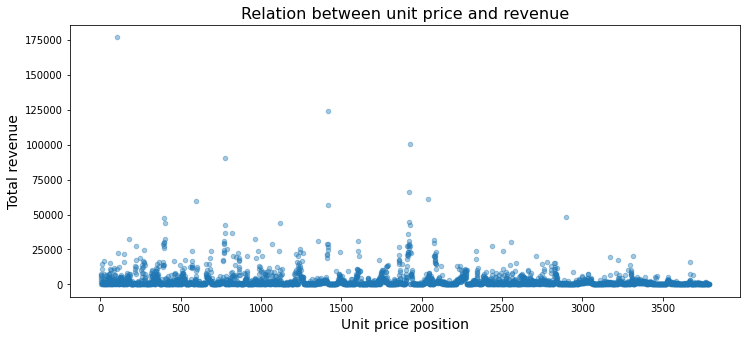

In [67]:
scatter('Relation between unit price and revenue',
     'unit_price_position',
     'total_revenue',
     'Unit price position',
     'Total revenue')

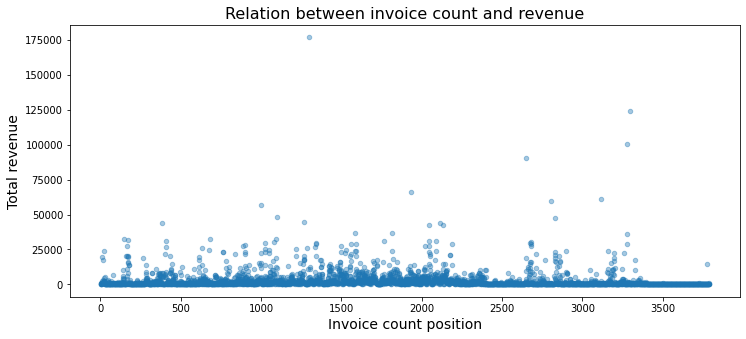

In [68]:
scatter('Relation between invoice count and revenue',
     'invoice_count_position',
     'total_revenue',
     'Invoice count position',
     'Total revenue')

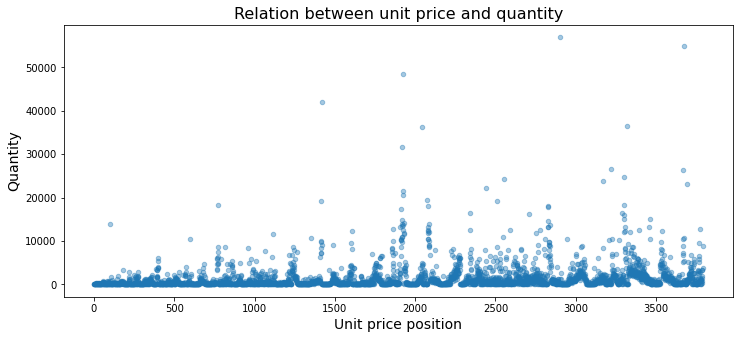

In [69]:
scatter('Relation between unit price and quantity',
     'unit_price_position',
     'quantity',
     'Unit price position',
     'Quantity')

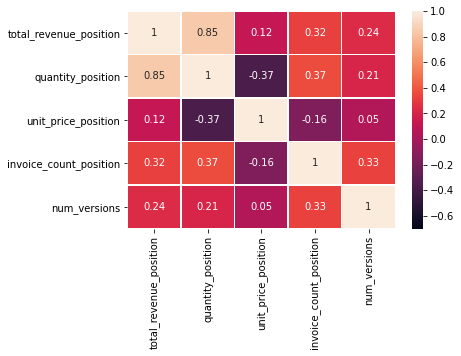

In [70]:
corr = positions.filter(['total_revenue_position', 'quantity_position', 'unit_price_position', 'invoice_count_position', 'num_versions'])
sns.heatmap(corr.corr(), annot = True, linewidth = 0.5, vmin= -0.7, vmax=1)
plt.show()

## Finding flagship products

**I will cluster the items based on the features we have found in the earlier stages.<br>
Also will use the description column to find common keywords and stemming those keywords, in order to find cluster the items by keywords.**

### Finding keywords

#### Stemming the description column

In [71]:
def stem_description(description):
    desc_stemmed = []
    for word in description.split(' '):
        if (len(word) > 2) &  word.isalpha():
            stemmed = snow_stemmer.stem(word)
            desc_stemmed.append(stemmed)
        else:
            pass
    if len(desc_stemmed) > 0:
        return desc_stemmed
    else:
        return 'no keyword'

In [72]:
positions['stemmed'] = positions['description'].apply(stem_description)

items = positions.copy()

items = items.explode('stemmed')

items.head()

,stock_code,description,quantity,unit_price,total_revenue,num_versions,more_than_1,total_revenue_position,quantity_position,unit_price_position,invoice_count,invoice_count_position,stemmed
0,22423,regency cakestand 3 tier,13862,12.75,176740.50,1,False,1.0,37.0,103.0,2009,1301.0,regenc
0,22423,regency cakestand 3 tier,13862,12.75,176740.50,1,False,1.0,37.0,103.0,2009,1301.0,cakestand
0,22423,regency cakestand 3 tier,13862,12.75,176740.50,1,False,1.0,37.0,103.0,2009,1301.0,tier
1,85123a,white hanging heart t-light holder,41937,2.95,123714.15,1,False,2.0,4.0,1418.0,2325,3295.0,white
1,85123a,white hanging heart t-light holder,41937,2.95,123714.15,1,False,2.0,4.0,1418.0,2325,3295.0,hang


In [79]:
keywords = items.groupby('stemmed').agg({'stock_code': 'count',
                                             'quantity': ['mean', 'sum'],
                                             'total_revenue': ['mean', 'sum']}).reset_index()
keywords.columns = ['keyword', 'count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'total_revenue']

up(keywords, 'count').head()

,keyword,count,avg_quantity,total_quantity,avg_revenue,total_revenue
1301,set,308,1544.094156,475581,3326.412435,1024535.03
1108,pink,294,967.887755,284559,1638.075476,481594.19
694,heart,246,1844.743902,453807,3391.641260,834343.75
129,blue,211,778.379147,164238,1358.454502,286633.90
1587,vintag,199,1846.507538,367455,3655.165327,727377.90


In [82]:
keywords_count = position(up(keywords, 'count').reset_index(drop = True), 'count')

keywords_avg_quantity = position(up(keywords, 'avg_quantity').reset_index(drop = True), 'avg_quantity')

keywords_quantity = position(up(keywords, 'total_quantity').reset_index(drop = True), 'total_quantity')

keyword_avg_revenue = position(up(keywords, 'avg_revenue').reset_index(drop = True), 'avg_revenue')

keyword_revenue = position(up(keywords, 'total_revenue').reset_index(drop = True), 'total_revenue')

In [83]:
keywords = pd.merge(keywords, keywords_count,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])
keywords = pd.merge(keywords, keywords_avg_quantity,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])
keywords = pd.merge(keywords, keywords_quantity,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])
keywords = pd.merge(keywords, keyword_avg_revenue,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])
keywords = pd.merge(keywords, keyword_revenue,  how = 'left', left_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'], right_on = ['keyword','count', 'avg_quantity', 'total_quantity', 'avg_revenue', 'avg_revenue', 'total_revenue'])

In [84]:
up(keywords, 'count').head()

,keyword,count,avg_quantity,total_quantity,avg_revenue,total_revenue,count_position,avg_quantity_position,total_quantity_position,avg_revenue_position,total_revenue_position
1301,set,308,1544.094156,475581,3326.412435,1024535.03,1.0,405.0,2.0,366.0,2.0
1108,pink,294,967.887755,284559,1638.075476,481594.19,2.0,610.0,11.0,664.0,11.0
694,heart,246,1844.743902,453807,3391.641260,834343.75,3.0,338.0,3.0,362.0,4.0
129,blue,211,778.379147,164238,1358.454502,286633.90,4.0,726.0,26.0,754.0,23.0
1587,vintag,199,1846.507538,367455,3655.165327,727377.90,5.0,336.0,5.0,320.0,6.0


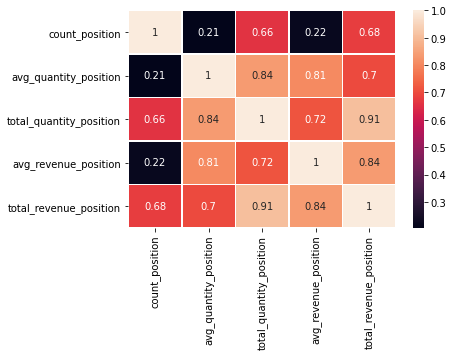

In [293]:
corr = keywords.filter(['count_position', 'avg_quantity_position', 'total_quantity_position', 'avg_revenue_position', 'total_revenue_position'])
sns.heatmap(corr.corr(), annot = True, linewidth = 0.5)
plt.show()

In [78]:
words = dict(zip(keywords['keyword'].tolist(), keywords['count'].tolist()))

In [79]:
def top_keywords(description):
    result = []
    for word in description.split():
        word = snow_stemmer.stem(word)
        if word in words:
            result.append(words[word])
        else:
            pass
    if len(result) == 0:
        result.append(0)
    return result

In [80]:
from statistics import mean, median

positions['min'] = (positions['description'].apply(top_keywords)).apply(min)
positions['median'] = (positions['description'].apply(top_keywords)).apply(median).astype(int)
positions['max'] = (positions['description'].apply(top_keywords)).apply(max)

In [81]:
positions.head(10)

,stock_code,description,quantity,unit_price,total_revenue,num_versions,more_than_1,total_revenue_position,quantity_position,unit_price_position,invoice_count,invoice_count_position,stemmed,min,median,max
0,22423,regency cakestand 3 tier,13862,12.75,176740.50,1,False,1.0,37.0,103.0,2009,1301.0,"[regenc, cakestand, tier]",2,10,17
1,85123a,white hanging heart t-light holder,41937,2.95,123714.15,1,False,2.0,4.0,1418.0,2325,3295.0,"[white, hang, heart, holder]",95,117,246
2,85099b,jumbo bag red retrospot,48375,2.08,100620.00,3,True,3.0,3.0,1926.0,2112,3279.0,"[jumbo, bag, red, retrospot]",25,127,191
3,47566,party bunting,18287,4.95,90520.65,1,False,4.0,20.0,773.0,1700,2650.0,"[parti, bunt]",18,30,43
4,23084,rabbit night light,31673,2.08,65879.84,1,False,5.0,7.0,1921.0,1030,1933.0,"[rabbit, night, light]",6,30,34
5,84879,assorted colour bird ornament,36362,1.69,61451.78,1,False,6.0,6.0,2042.0,1476,3118.0,"[assort, colour, bird, ornament]",1,47,58
6,79321,chilli lights,10419,5.75,59909.25,1,False,7.0,79.0,596.0,674,2807.0,"[chilli, light]",1,17,34
7,22086,paper chain kit 50's christmas,19329,2.95,57020.55,1,False,8.0,18.0,1416.0,1184,999.0,"[paper, chain, kit, christma]",11,51,145
8,22197,popcorn holder,56898,0.85,48363.30,1,False,9.0,1.0,2900.0,1418,1101.0,"[popcorn, holder]",2,55,108
9,82484,wood black board ant white finish,6012,7.95,47795.40,1,False,10.0,199.0,399.0,685,2829.0,"[wood, black, board, ant, white, finish]",5,25,126


In [82]:
positions.corr()

,quantity,unit_price,total_revenue,num_versions,more_than_1,total_revenue_position,quantity_position,unit_price_position,invoice_count,invoice_count_position,min,median,max
quantity,1.000000,-0.107428,0.683629,-0.093375,-0.154627,-0.491029,-0.572484,0.202304,0.780447,-0.136905,0.085870,0.075583,0.022475
unit_price,-0.107428,1.000000,0.055421,-0.032064,-0.021055,-0.076848,0.217420,-0.482286,-0.071305,0.056143,-0.051609,-0.042533,-0.038875
total_revenue,0.683629,0.055421,1.000000,-0.085427,-0.137999,-0.521418,-0.449321,-0.136255,0.809467,-0.089623,0.058046,0.036767,0.016002
num_versions,-0.093375,-0.032064,-0.085427,1.000000,0.555285,0.240317,0.211229,0.049752,-0.127099,0.331616,0.105628,0.034424,-0.048735
more_than_1,-0.154627,-0.021055,-0.137999,0.555285,1.000000,0.372356,0.346997,-0.024777,-0.217348,0.513927,0.071795,0.066262,0.042902
total_revenue_position,-0.491029,-0.076848,-0.521418,0.240317,0.372356,1.000000,0.853001,0.121189,-0.688640,0.323152,-0.039175,-0.004122,-0.017773
quantity_position,-0.572484,0.217420,-0.449321,0.211229,0.346997,0.853001,1.000000,-0.366864,-0.689051,0.366059,-0.070966,-0.018482,-0.000100
unit_price_position,0.202304,-0.482286,-0.136255,0.049752,-0.024777,0.121189,-0.366864,1.000000,0.042758,-0.155236,0.049951,0.030129,-0.025906
invoice_count,0.780447,-0.071305,0.809467,-0.127099,-0.217348,-0.688640,-0.689051,0.042758,1.000000,-0.204252,0.073091,0.058567,0.055489
invoice_count_position,-0.136905,0.056143,-0.089623,0.331616,0.513927,0.323152,0.366059,-0.155236,-0.204252,1.000000,0.054194,0.092103,0.042086


In [83]:
items_ml = positions[['stock_code',
                      'total_revenue_position', 
                      'quantity_position', 
                      'unit_price_position', 
                      'invoice_count_position', 
                      'more_than_1', 
                      'min', 'median', 'max']].set_index('stock_code')

In [84]:
scaler = StandardScaler()
items_st = scaler.fit_transform(items_ml)

In [85]:
linked = linkage(items_st, method = 'ward')

In [86]:
model_km = KMeans(n_clusters = 8)

# get labels
labels_km = model_km.fit_predict(items_st)

In [87]:
positions['cluster_labels'] = labels_km

clusters = positions['cluster_labels'].value_counts().reset_index().rename(columns = {'index': 'cluster'})
down(clusters, 'cluster')

,cluster,cluster_labels
0,0,664
2,1,610
7,2,168
1,3,617
5,4,390
4,5,470
6,6,263
3,7,608


In [88]:
positions['stock_number'] = positions['stock_code'].str.replace('[a-zA-Z]', '', regex = True)

In [89]:
positions.head()

,stock_code,description,quantity,unit_price,total_revenue,num_versions,more_than_1,total_revenue_position,quantity_position,unit_price_position,invoice_count,invoice_count_position,stemmed,min,median,max,cluster_labels,stock_number
0,22423,regency cakestand 3 tier,13862,12.75,176740.50,1,False,1.0,37.0,103.0,2009,1301.0,"[regenc, cakestand, tier]",2,10,17,7,22423
1,85123a,white hanging heart t-light holder,41937,2.95,123714.15,1,False,2.0,4.0,1418.0,2325,3295.0,"[white, hang, heart, holder]",95,117,246,2,85123
2,85099b,jumbo bag red retrospot,48375,2.08,100620.00,3,True,3.0,3.0,1926.0,2112,3279.0,"[jumbo, bag, red, retrospot]",25,127,191,3,85099
3,47566,party bunting,18287,4.95,90520.65,1,False,4.0,20.0,773.0,1700,2650.0,"[parti, bunt]",18,30,43,7,47566
4,23084,rabbit night light,31673,2.08,65879.84,1,False,5.0,7.0,1921.0,1030,1933.0,"[rabbit, night, light]",6,30,34,7,23084


In [90]:
clusters = positions.groupby('cluster_labels').agg({
            'stock_code': 'count', 
            'quantity':'mean', 
            'unit_price': 'mean', 
            'total_revenue': ['mean', 'sum'], 
            'stock_number': 'nunique', 
            'more_than_1': 'mean'})

clusters.columns = ['total_items', 'avg_sales', 'avg_price', 'avg_revenue', 'total_revenue', 'unique_items', 'variety']

clusters.style.highlight_max(color = '#97DFA1').highlight_min(color = '#FCA965')

,total_items,avg_sales,avg_price,avg_revenue,total_revenue,unique_items,variety
cluster_labels,,,,,,,
0,664,3030.365964,0.871205,2487.623163,1651781.780000,661,0.021084
1,610,191.421311,3.321459,298.715246,182216.300000,234,1.000000
2,168,1592.714286,2.693095,2586.708155,434566.970000,135,0.410714
3,617,3097.883306,2.591491,5580.590859,3443224.560000,608,0.040519
4,390,95.894872,4.766538,257.757385,100525.380000,388,0.000000
5,470,164.731915,3.574809,347.589298,163366.970000,457,0.055319
6,263,99.030418,3.625323,262.549886,69050.620000,261,0.060837
7,608,1663.514803,7.090609,6923.676464,4209595.290000,604,0.018092
